<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Glaucoma_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import tensorflow as tf
from ipywidgets import interact
from sklearn import preprocessing

In [3]:
def index_shuffle(f, random_state=4):
  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  # test_size = 1/k
  # [x*test_size for x in list(range(0, 33, test_size*32))]
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)


  return ix_train, ix_test

# Data Acquisition

In [4]:
path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/'

In [5]:
df = pd.read_json(path+'dataframe_new.json')

In [10]:
gl_ix = df.index[df['tag']=='Glaucoma'].tolist()
n_ix = df.index[df['tag']=='Normal'].tolist()
dr_gl_ix = [x for x in gl_ix if x < 50]
re_gl_ix = [x for x in gl_ix if x >= 50]
dr_n_ix = [x for x in n_ix if x < 50]
re_n_ix = [x for x in n_ix if x >= 50]
print(len(dr_gl_ix)+len(dr_n_ix))
print(len(re_gl_ix)+len(re_n_ix))

50
400


In [ ]:
def CDR_calc(OD_mask, OC_mask):
  try:
    c_OD,_ = cv2.findContours(OD_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OD = cv2.approxPolyDP(c_OD[0], 3, True)
    c_OC,_ = cv2.findContours(OC_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OC = cv2.approxPolyDP(c_OC[0], 3, True)
    x_OD, y_OD, hor_OD, ver_OD = cv2.boundingRect(p_OD)
    x_OC, y_OC, hor_OC, ver_OC = cv2.boundingRect(p_OC)
    

    VCDR = ver_OC/ver_OD # vertical CDR
    HCDR = hor_OC/ hor_OD # Horizontal CDR
    ACDR = np.sum(OC_mask == 255)/ np.sum(OD_mask == 255) # Area CDR


  except:
    VCDR = float("nan")
    HCDR = float("nan")
    ACDR = float("nan")
  
  return VCDR, HCDR, ACDR

In [ ]:
# vertical CDR perhitungan mandiri pada mask gt
VCDR_gtm = []
VCDR_seg = []
VCDR_gtm = []
VCDR_seg = []
HCDR_gtm = []
HCDR_seg = []
ACDR_gtm = []
ACDR_seg = []
nan_ix = []
for i in tqdm(range(len(df))):
  OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  OD_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  OC_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  VCDR_gt, HCDR_gt, ACDR_gt = CDR_calc(OD_gt, OC_gt)
  VCDR_sg, HCDR_sg, ACDR_sg = CDR_calc(OD_seg, OC_seg)

  VCDR_gtm.append(VCDR_gt)
  VCDR_seg.append(VCDR_sg)
  HCDR_gtm.append(HCDR_gt)
  HCDR_seg.append(HCDR_sg)
  ACDR_gtm.append(ACDR_gt)
  ACDR_seg.append(ACDR_sg)
  if np.isnan(VCDR_sg):
    nan_ix.append(i)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
inf_df = pd.DataFrame({'VCDR Gold': VCDR_gtn, 'VCDR': VCDR_seg, 'HCDR': HCDR_seg, 
                       'ACDR': ACDR_seg, 'VCDR GT': VCDR_gtm, 'HCDR GT': HCDR_gtm,
                       'ACDR GT': ACDR_gtm, 'tag': df['tag'].tolist()})
inf_df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.csv')
inf_df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

In [6]:
inf_df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

# Data Exploration

In [7]:
def make_linear(X, Y):
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  return Y_pred

def r_squared(X, Y):
  X = X.squeeze()
  Y = Y.squeeze()
  correlation_matrix = np.corrcoef(X, Y)
  correlation_xy = correlation_matrix[0,1]
  r_square = correlation_xy**2
  return r_square

Hubungan antara vairabel

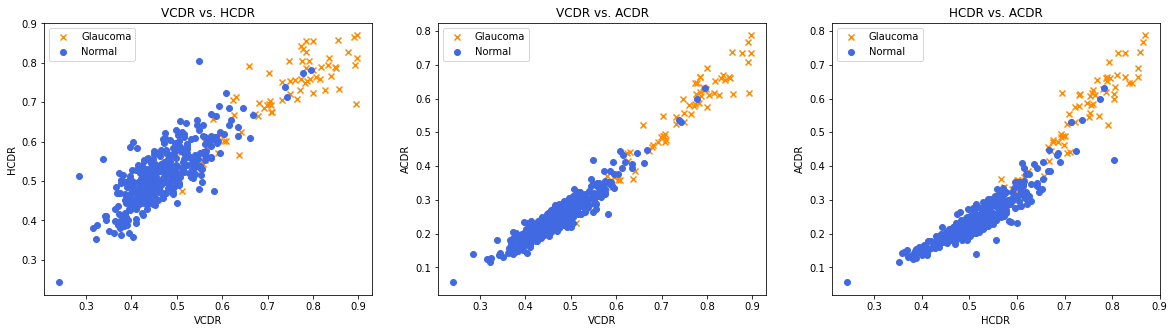

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[0].set_title('VCDR vs. HCDR')
ax[0].set_xlabel('VCDR')
ax[0].set_ylabel('HCDR')
ax[0].legend()
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[1].set_title('VCDR vs. ACDR')
ax[1].set_xlabel('VCDR')
ax[1].set_ylabel('ACDR')
ax[1].legend()
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[2].set_title('HCDR vs. ACDR')
ax[2].set_xlabel('HCDR')
ax[2].set_ylabel('ACDR')
ax[2].legend()
plt.show()

**VCDR Analysis**

Absolute error in all cases: 0.00498
Absolute error in glaucoma cases: 0.00541
Absolute error in normal cases: 0.00473


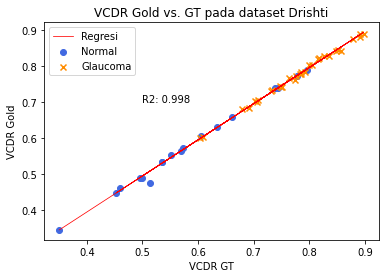

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][:50]-inf_df['VCDR GT'][:50]))/ 50
xo = inf_df['VCDR GT'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR GT'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR GT'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR Gold'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal')
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma')
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR GT')
plt.title('VCDR Gold vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04153
Absolute error in glaucoma cases: 0.03707
Absolute error in normal cases: 0.04404


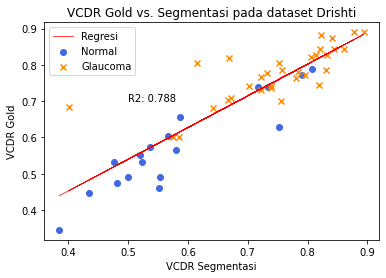

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][:50]-inf_df['VCDR'][:50]))/ 50
xo = inf_df['VCDR'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR Gold'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal')
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma')
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Gold vs. Segmentasi pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04226
Absolute error in glaucoma cases: 0.03699
Absolute error in normal cases: 0.04522


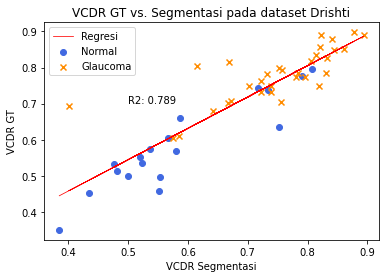

In [22]:
abs_e = np.sum(abs(inf_df['VCDR GT'][:50]-inf_df['VCDR'][:50]))/ 50
xo = inf_df['VCDR'][dr_n_ix]
yo = inf_df['VCDR GT'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR'][dr_gl_ix]
yi = inf_df['VCDR GT'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal')
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma')
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR GT vs. Segmentasi pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.03311
Absolute error in glaucoma cases: 0.03135
Absolute error in normal cases: 0.04238


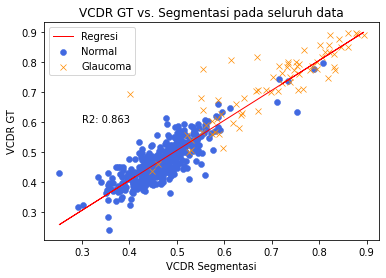

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT']-inf_df['VCDR']))/ len(inf_df['VCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['VCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['VCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['VCDR'].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal', lw=0.5)
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma', lw=0.7)
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR GT vs. Segmentasi pada seluruh data')
plt.text(0.3, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.03695
Absolute error in glaucoma cases: 0.03662
Absolute error in normal cases: 0.03568


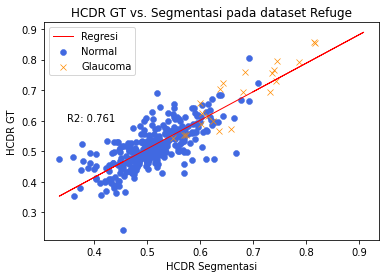

In [21]:
abs_e = np.sum(abs(inf_df['HCDR GT'][50:]-inf_df['HCDR'][50:]))/ len(inf_df['HCDR'][50:])
xo = inf_df.loc[inf_df['tag']=='Normal']['HCDR'][50:]
yo = inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'][50:]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR'][50:]
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'][50:]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['HCDR'].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal', lw=0.5)
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma', lw=0.7)
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR GT vs. Segmentasi pada dataset Refuge')
plt.text(0.35, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.03835
Absolute error in glaucoma cases: 0.03698
Absolute error in normal cases: 0.04554


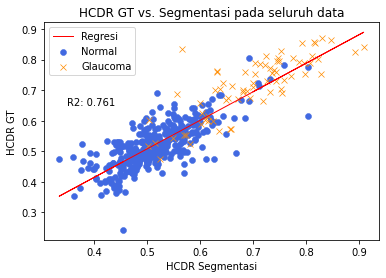

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT']-inf_df['HCDR']))/ len(inf_df['HCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['HCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['HCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


x = inf_df['HCDR'].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal', lw=0.5)
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma', lw=0.7)
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR GT vs. Segmentasi pada seluruh data')
plt.text(0.35, 0.65, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.02986
Absolute error in glaucoma cases: 0.02610
Absolute error in normal cases: 0.04961


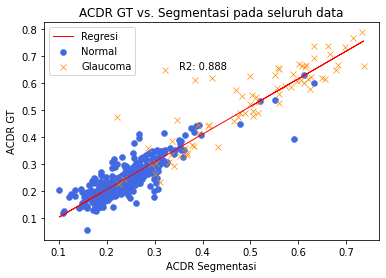

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT']-inf_df['ACDR']))/ len(inf_df['ACDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['ACDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['ACDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


x = inf_df['ACDR'].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal', lw=0.5)
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma', lw=0.7)
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR GT vs. Segmentasi pada seluruh data')
plt.text(0.35, 0.65, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

**Limit of Agreement**

GT number vs. GT mask

GT mask vs. Segmentation

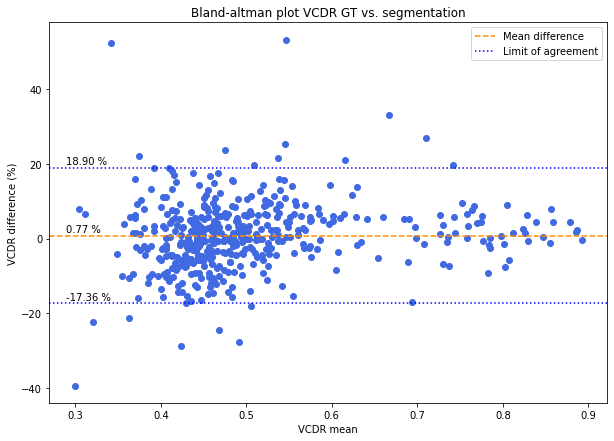

In [ ]:
val1 = inf_df['VCDR GT'].to_numpy()
val2 = inf_df['VCDR'].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='royalblue')
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(np.min(rata2) - 0.01, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT vs. segmentation')
plt.ylabel('VCDR difference (%)')
plt.xlabel('VCDR mean')
plt.show()

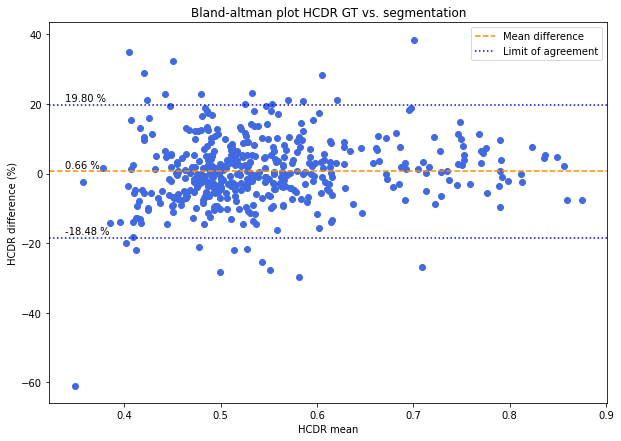

In [ ]:
val1 = inf_df['HCDR GT'].to_numpy()
val2 = inf_df['HCDR'].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='royalblue')
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(np.min(rata2) - 0.01, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot HCDR GT vs. segmentation')
plt.ylabel('HCDR difference (%)')
plt.xlabel('HCDR mean')
plt.show()

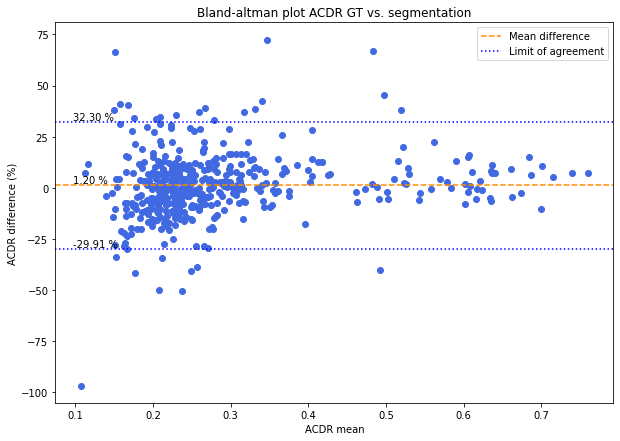

In [ ]:
val1 = inf_df['ACDR GT'].to_numpy()
val2 = inf_df['ACDR'].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='royalblue')
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(np.min(rata2) - 0.01, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot ACDR GT vs. segmentation')
plt.ylabel('ACDR difference (%)')
plt.xlabel('ACDR mean')
plt.show()

GT number vs. Segmentation

In [ ]:
val1 = [x for x in VCDR_gtn if not np.isnan(x)]
val2 = VCDR_seg[:50]
diff = val1 - val2
rata2 = (val1 + val2) /2
mean = np.mean(diff)
std = np.std(diff)
plt.figure(figsize=(10,7))
plt.scatter(rata2, diff, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.002, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.002, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.002, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT mask vs. segmentation Drishti')
plt.ylabel('VCDR difference')
plt.xlabel('VCDR mean')
plt.show()

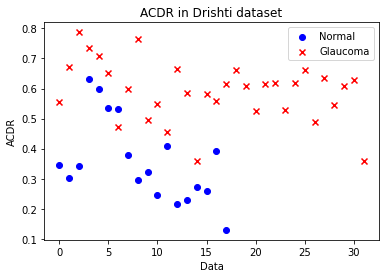

In [ ]:
plt.scatter(range(len(dr.loc[dr['tag']=='Normal'])), ACDR_gt[dr.index[dr['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(dr.loc[dr['tag']=='Glaucoma'])), ACDR_gt[dr.index[dr['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('ACDR')
plt.xlabel('Data')
plt.title('ACDR in Drishti dataset')
plt.legend()
plt.show()

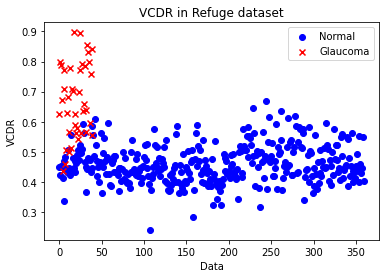

In [ ]:
plt.scatter(range(len(re.loc[re['tag']=='Normal'])), VCDR_gt[re.index[re['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(re.loc[re['tag']=='Glaucoma'])),VCDR_gt[re.index[re['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('VCDR in Refuge dataset')
plt.legend()
plt.show()

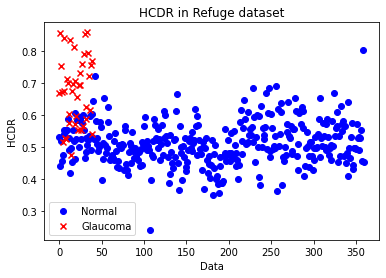

In [ ]:
plt.scatter(range(len(re.loc[re['tag']=='Normal'])), HCDR_gt[re.index[re['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(re.loc[re['tag']=='Glaucoma'])),HCDR_gt[re.index[re['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('HCDR')
plt.xlabel('Data')
plt.title('HCDR in Refuge dataset')
plt.legend()
plt.show()

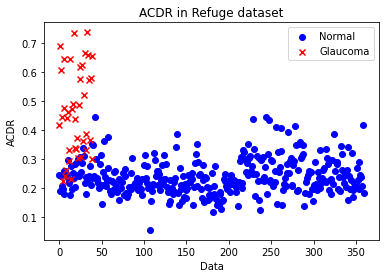

In [ ]:
plt.scatter(range(len(re.loc[re['tag']=='Normal'])), ACDR_gt[re.index[re['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(re.loc[re['tag']=='Glaucoma'])),ACDR_gt[re.index[re['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('ACDR')
plt.xlabel('Data')
plt.title('ACDR in Refuge dataset')
plt.legend()
plt.show()

# Glaucoma Inference

In [63]:
inf_df.groupby('tag').size()

tag
Glaucoma     72
Normal      378
dtype: int64

In [23]:
feature_columns1 = ['VCDR']
feature_columns_GT1 = ['VCDR GT']
x1 = inf_df[feature_columns1].to_numpy()
x1_GT = inf_df[feature_columns_GT1].to_numpy()

feature_columns2 = ['VCDR', 'ACDR']
feature_columns_GT2 = ['VCDR GT', 'ACDR GT']
x2 = inf_df[feature_columns2].to_numpy()
x2_GT = inf_df[feature_columns_GT2].to_numpy()

feature_columns3 = ['VCDR', 'HCDR']
feature_columns_GT3 = ['VCDR GT', 'HCDR GT']
x3 = inf_df[feature_columns3].to_numpy()
x3_GT = inf_df[feature_columns_GT3].to_numpy()

feature_columns4 = ['VCDR', 'ACDR', 'HCDR']
feature_columns_GT4 = ['VCDR GT', 'ACDR GT', 'HCDR GT']
x4 = inf_df[feature_columns4].to_numpy()
x4_GT = inf_df[feature_columns_GT4].to_numpy()

tag_column = ['tag']


y = inf_df[tag_column].to_numpy()
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
print(list(le.classes_))

['Glaucoma', 'Normal']


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
train_ix, test_ix = index_shuffle(f=2)

Logistic : Acc = 0.888
SVM 1: Acc = 0.944
SVM 2: Acc = 0.944
SVM 3: Acc = 0.944
SVM 4: Acc = 0.944

No Skill: ROC AUC=0.500
Logistic : ROC AUC=0.989
SVM 1: ROC AUC=0.989
SVM 2: ROC AUC=0.990
SVM 3: ROC AUC=0.939
SVM 4: ROC AUC=0.989


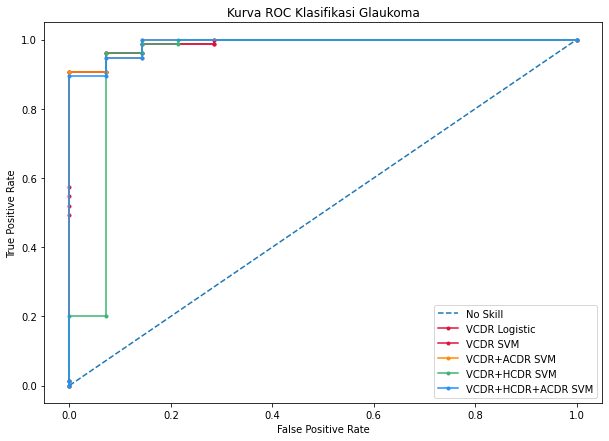

In [27]:
# roc curve and auc
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# split into train/test sets
trainX1 = x1_GT[train_ix]
testX1 = x1_GT[test_ix]
trainX2 = x2_GT[train_ix]
testX2 = x2_GT[test_ix]
trainX3 = x3_GT[train_ix]
testX3 = x3_GT[test_ix]
trainX4 = x4_GT[train_ix]
testX4 = x4_GT[test_ix]
trainy = y[train_ix] 
testy = y[test_ix]
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model0 = LogisticRegression(solver='lbfgs')
model1 = svm.SVC(probability=True)
model2 = svm.SVC(probability=True)
model3 = svm.SVC(probability=True)
model4 = svm.SVC(probability=True)

model0.fit(trainX1, trainy)
model1.fit(trainX1, trainy)
model2.fit(trainX2, trainy)
model3.fit(trainX3, trainy)
model4.fit(trainX4, trainy)

# predict probabilities
lr0_probs = model0.predict_proba(testX1)
lr1_probs = model1.predict_proba(testX1)
lr2_probs = model2.predict_proba(testX2)
lr3_probs = model3.predict_proba(testX3)
lr4_probs = model4.predict_proba(testX4)

# predict class
lr0 = model0.predict(testX1)
lr1 = model1.predict(testX1)
lr2 = model2.predict(testX2)
lr3 = model3.predict(testX3)
lr4 = model4.predict(testX4)

# Calculate accuracy
acc0 = accuracy_score(testy, lr0)
acc1 = accuracy_score(testy, lr1)
acc2 = accuracy_score(testy, lr2)
acc3 = accuracy_score(testy, lr3)
acc4 = accuracy_score(testy, lr4)

# keep probabilities for the positive outcome only
lr0_probs = lr0_probs[:, 1]
lr1_probs = lr1_probs[:, 1]
lr2_probs = lr2_probs[:, 1]
lr3_probs = lr3_probs[:, 1]
lr4_probs = lr4_probs[:, 1]

# summarize scores
print('Logistic : Acc = %.3f' % (acc0))
print('SVM 1: Acc = %.3f' % (acc1))
print('SVM 2: Acc = %.3f' % (acc2))
print('SVM 3: Acc = %.3f' % (acc3))
print('SVM 4: Acc = %.3f' % (acc4))
print()

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr0_auc = roc_auc_score(testy, lr0_probs)
lr1_auc = roc_auc_score(testy, lr1_probs)
lr2_auc = roc_auc_score(testy, lr2_probs)
lr3_auc = roc_auc_score(testy, lr3_probs)
lr4_auc = roc_auc_score(testy, lr4_probs)
# dr_auc = roc_auc_score(testy, testX)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic : ROC AUC=%.3f' % (lr1_auc))
print('SVM 1: ROC AUC=%.3f' % (lr1_auc))
print('SVM 2: ROC AUC=%.3f' % (lr2_auc))
print('SVM 3: ROC AUC=%.3f' % (lr3_auc))
print('SVM 4: ROC AUC=%.3f' % (lr4_auc))
# print('VCDR: ROC AUC=%.3f' % (cdr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr0_fpr, lr0_tpr, _ = roc_curve(testy, lr0_probs)
lr1_fpr, lr1_tpr, _ = roc_curve(testy, lr1_probs)
lr2_fpr, lr2_tpr, _ = roc_curve(testy, lr2_probs)
lr3_fpr, lr3_tpr, _ = roc_curve(testy, lr3_probs)
lr4_fpr, lr4_tpr, _ = roc_curve(testy, lr4_probs)
# cdr_fpr, cdr_tpr, _ = roc_curve(testy, testX)
# plot the roc curve for the model
plt.figure(figsize=(10, 7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr0_fpr, lr0_tpr, marker='.', label='VCDR Logistic', color='crimson')
plt.plot(lr1_fpr, lr1_tpr, marker='.', label='VCDR SVM', color='crimson')
plt.plot(lr2_fpr, lr2_tpr, marker='.', label='VCDR+ACDR SVM', color='darkorange')
plt.plot(lr3_fpr, lr3_tpr, marker='.', label='VCDR+HCDR SVM', color='mediumseagreen')
plt.plot(lr4_fpr, lr4_tpr, marker='.', label='VCDR+HCDR+ACDR SVM', color='dodgerblue')
# plt.plot(cdr_fpr, cdr_tpr, marker='.', label='VCDR value', color='crimson')
# axis labels
plt.title('Kurva ROC Klasifikasi Glaukoma')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# predict class
lr0 = model0.predict(x1)
lr1 = model1.predict(x1)
lr2 = model2.predict(x2)
lr3 = model3.predict(x3)
lr4 = model4.predict(x4)

# Calculate accuracy
acc0 = accuracy_score(y, lr0)
acc1 = accuracy_score(y, lr1)
acc2 = accuracy_score(y, lr2)
acc3 = accuracy_score(y, lr3)
acc4 = accuracy_score(y, lr4)

# summarize scores
print('Logistic : Acc = %.3f' % (acc0))
print('SVM 1: Acc = %.3f' % (acc1))
print('SVM 2: Acc = %.3f' % (acc2))
print('SVM 3: Acc = %.3f' % (acc3))
print('SVM 4: Acc = %.3f' % (acc4))
print()

Logistic : Acc = 0.876
SVM 1: Acc = 0.927
SVM 2: Acc = 0.929
SVM 3: Acc = 0.927
SVM 4: Acc = 0.922



In [28]:
def threshold_pred(CDRS, threshold):
  pred = []
  for CDR in CDRS:
    if CDR< threshold:
      pred.append('Normal')
    elif CDR>= threshold:
      pred.append('Glaucoma')
  pred = np.array(pred)
  return pred

In [55]:
thresholds = []
akurasi_GT = []
akurasi = []
for i in range(50):
  thd = 0.3 + i/100
  y_pred = threshold_pred(x1[:50], threshold=thd)
  y_pred_GT = threshold_pred(x1_GT[:50], threshold=thd)
  y_pred = le.transform(y_pred)
  y_pred_GT = le.transform(y_pred_GT)

  acc_m = tf.keras.metrics.BinaryAccuracy()
  acc_m.update_state(y_pred, y[:50])
  acc = acc_m.result().numpy()
  acc_m.update_state(y_pred_GT, y[:50])
  acc_GT = acc_m.result().numpy()

  thresholds.append(thd)
  akurasi_GT.append(acc_GT)
  akurasi.append(acc)
  #print('Thershold: {:.3f} - Accuracy GT: {:.3f} - Accuracy Segmentation: {:.3f}'.format(thd, acc_GT, acc))

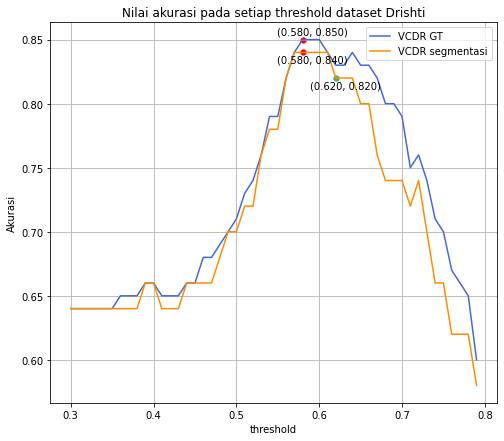

In [61]:
X = thresholds
Y_GT = akurasi_GT
Y = akurasi
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
max_acc_GT = np.max(Y_GT)
max_thd = X[Y_GT.index(max_acc_GT)]
max_acc = Y[Y_GT.index(max_acc_GT)]
acc = Y[X.index(0.62)]
ax.plot(X, Y_GT, color='royalblue', label='VCDR GT')
ax.plot(X, Y, color='darkorange', label='VCDR segmentasi')
ax.scatter(max_thd, max_acc_GT, marker='o', color='r', lw=0.25)
ax.scatter(max_thd, max_acc, marker='o', color='r', lw=0.25)
ax.scatter(0.62, acc, marker='o', color='mediumseagreen', lw=0.25)
ax.set_xlabel('threshold')
ax.set_ylabel('Akurasi')
ax.text(max_thd-0.031, max_acc_GT+0.004, '({:.3f}, {:.3f})'.format(max_thd, max_acc_GT), size='medium')
ax.text(max_thd-0.031, max_acc-0.008, '({:.3f}, {:.3f})'.format(max_thd, max_acc), size='medium')
ax.text(0.62-0.031, acc-0.008, '({:.3f}, {:.3f})'.format(0.620, acc), size='medium')
ax.grid()
ax.set_title('Nilai akurasi pada setiap threshold dataset Drishti')
ax.legend()
plt.show()